In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from sklearn.decomposition import PCA

In [34]:
terror = pd.read_csv('terrorism_new.csv')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (4,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [35]:
# select columns

cols = [
    'success','eventid','iyear','imonth','extended',
    'attacktype1_txt','weaptype1_txt','targtype1_txt',
    'claimed','gname','suicide','nperps',
    'nkill','nwound','property','propextent','propvalue'
]

terror = terror[cols]

In [87]:
terror.describe()

,success,eventid,iyear,imonth,extended,claimed,suicide,nperps,nkill,nwound,property,propextent,propvalue
count,191464.000000,1.914640e+05,191464.000000,191464.000000,191464.000000,125349.000000,191464.000000,120355.000000,180435.000000,173905.000000,191464.000000,67286.000000,4.219600e+04
mean,0.886825,2.003486e+11,2003.420136,6.462510,0.047476,0.065497,0.036618,-66.502140,2.410735,3.161232,-0.629319,3.291978,1.932884e+05
std,0.316808,1.334949e+09,13.349405,3.388515,0.212656,1.058084,0.187822,208.104397,11.445411,42.679122,3.212640,0.484213,1.492315e+07
min,0.000000,1.970000e+11,1970.000000,0.000000,0.000000,-9.000000,0.000000,-99.000000,0.000000,0.000000,-9.000000,1.000000,-9.900000e+01
25%,1.000000,1.991083e+11,1991.000000,4.000000,0.000000,0.000000,0.000000,-99.000000,0.000000,0.000000,0.000000,3.000000,-9.900000e+01
50%,1.000000,2.010031e+11,2010.000000,6.000000,0.000000,0.000000,0.000000,-99.000000,0.000000,0.000000,1.000000,3.000000,-9.900000e+01
75%,1.000000,2.015013e+11,2015.000000,9.000000,0.000000,0.000000,0.000000,-99.000000,2.000000,2.000000,1.000000,4.000000,-9.900000e+01
max,1.000000,2.018123e+11,2018.000000,12.000000,1.000000,1.000000,1.000000,25000.000000,1570.000000,10878.000000,1.000000,4.000000,2.700000e+09


## Counts

Successful attacks accounts for 88.7% of all attacks and 99.5% of all extended attacks are successful.

In [36]:
# total number of successful vs failed attacks
terror[['success']].value_counts()

success
1          169795
0           21669
dtype: int64

In [118]:
# total number of successful vs failed attacks when looking only at extended attacks

terror[terror['extended']==1]['success'].value_counts()

1    9046
0      44
Name: success, dtype: int64

## 1) Time-based trends

Text(0.5, 1.0, 'Number of successful and failed attacks over the years')

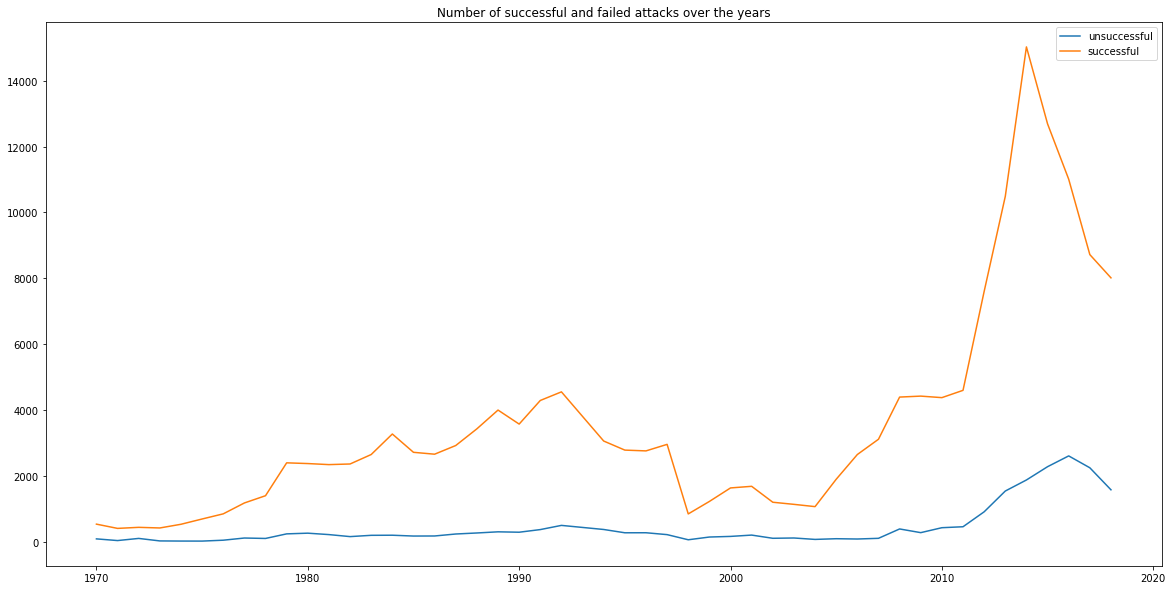

In [106]:
# number of successful vs failed attacks over the years
success_year_stats = terror.groupby(['iyear','success'])['eventid'].count().to_frame().reset_index()
success_year_stats = success_year_stats.rename(columns={'eventid': 'count'})
plt.figure(figsize=(20,10))
for i in range(2):
    label = 'successful' if i == 1 else 'unsuccessful'
    df = success_year_stats[success_year_stats['success']==i]
    plt.plot(df['iyear'], df['count'], label=label)
plt.legend()
plt.title('Number of successful and failed attacks over the years')

Text(0.5, 1.0, 'Proportion of successful attacks over the years')

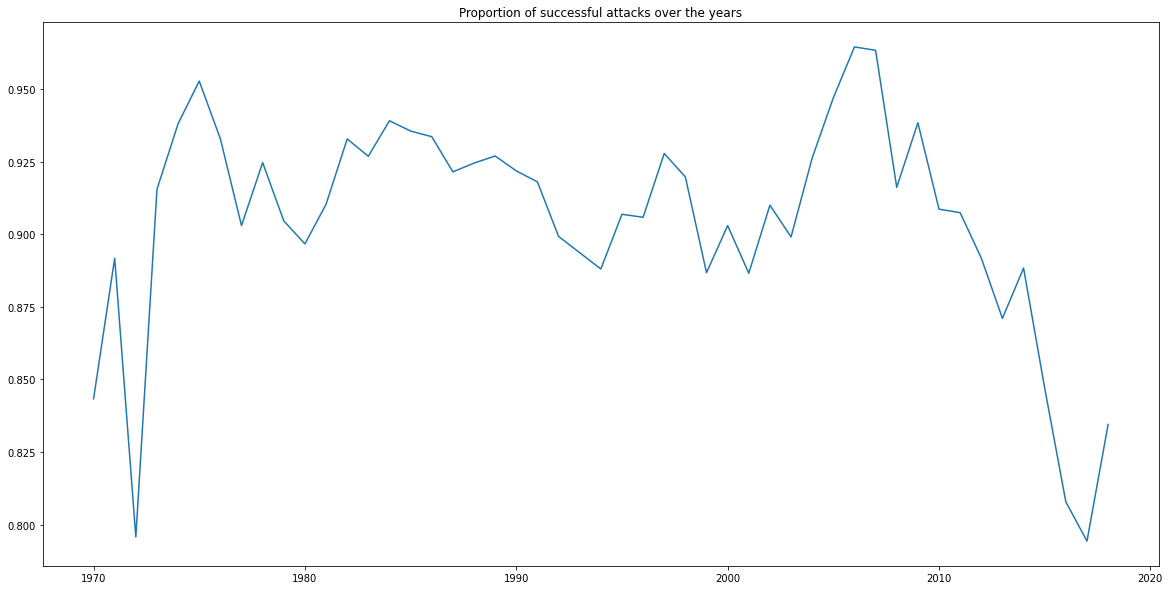

In [107]:
# proportion of successful attacks over time
total_attacks_by_year = terror.groupby('iyear')['eventid'].count().to_frame().reset_index()
total_attacks_by_year = total_attacks_by_year.rename(columns={'eventid':'total_count'})
proportion_success = success_year_stats[success_year_stats['success']==1].merge(total_attacks_by_year,on='iyear')
proportion_success['proportion_success'] = proportion_success['count'] / proportion_success['total_count']
plt.figure(figsize=(20,10))
plt.plot(proportion_success['iyear'], proportion_success['proportion_success'])
plt.title('Proportion of successful attacks over the years')

## 2) Severity of attacks

In [108]:
# terror['nperps'].value_counts()
# terror.isnull().sum(axis = 0)


Text(0.5, 1.0, 'Distribution of number of fatalities for successful vs unsuccessful attacks')

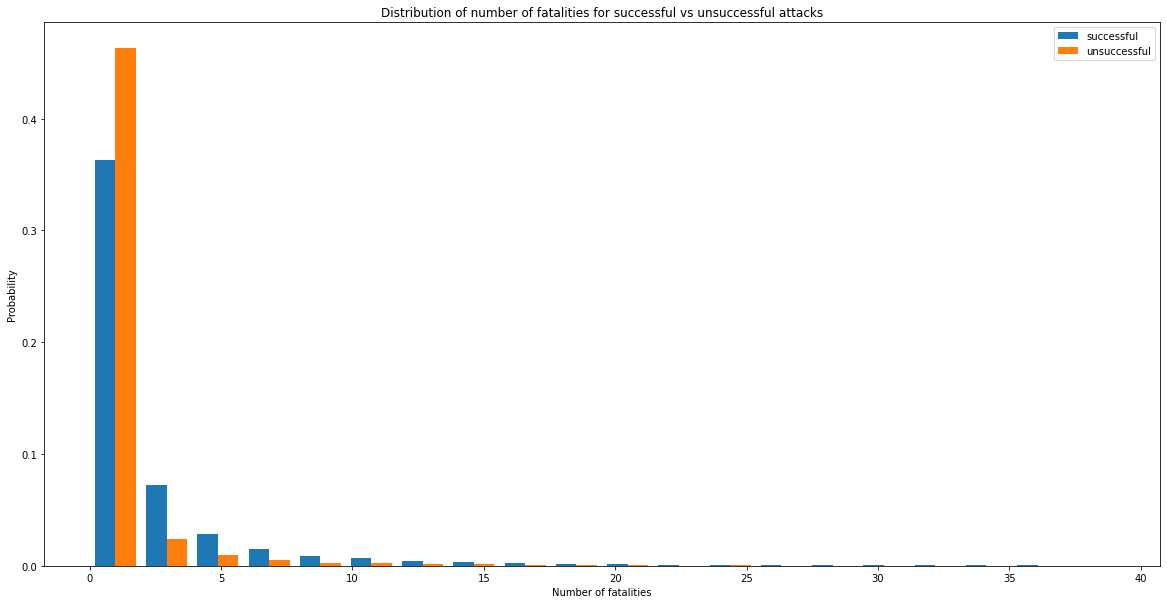

In [110]:
# Number of fatalities
nkill = terror[['eventid','success','nkill']].dropna()
nkill = nkill[nkill['nkill']<40] # ~ 3 SD above mean
plt.figure(figsize=(20,10))
plt.hist([nkill[nkill['success']==1]['nkill'],nkill[nkill['success']==0]['nkill']], density=True, bins=20, label=['successful','unsuccessful']) 
plt.ylabel('Probability')
plt.xlabel('Number of fatalities')
plt.legend()
plt.title('Distribution of number of fatalities for successful vs unsuccessful attacks')

Text(0.5, 1.0, 'Distribution of number of casualties for successful vs unsuccessful attacks')

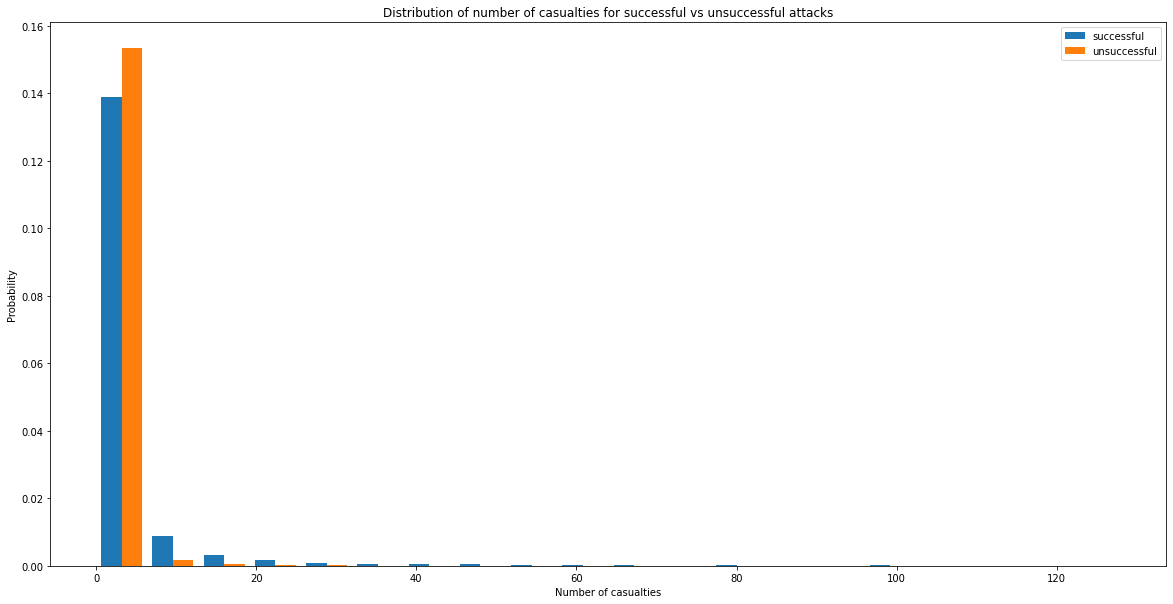

In [112]:
# Number of casualties
nwound = terror[['eventid','success','nwound']].dropna()
nwound = nwound[nwound['nwound']<130] # ~ 3*SD above mean
plt.figure(figsize=(20,10))
plt.hist([nwound[nwound['success']==1]['nwound'],nwound[nwound['success']==0]['nwound']], density=True, bins=20, label=['successful','unsuccessful']) 
plt.ylabel('Probability')
plt.xlabel('Number of casualties')
plt.legend()
plt.title('Distribution of number of casualties for successful vs unsuccessful attacks')

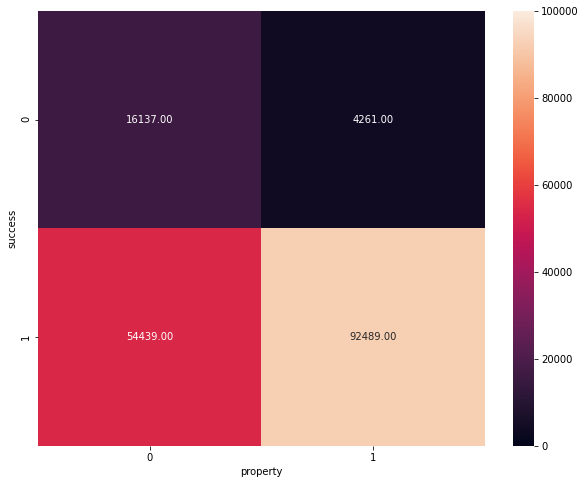

In [173]:
# Property damage
prop = terror[['eventid','property','success']]
prop = prop[prop['property'] != -9]
prop = prop.groupby(['property','success'])['eventid'].count().to_frame().reset_index()
prop = pd.pivot_table(prop, values='eventid',columns=['property'],index=['success'])
fig = plt.figure(figsize=(10,8))
res = sns.heatmap(prop, annot=True, vmin=0.0, vmax=100000, fmt='.2f')

Text(0.5, 1.0, 'Distribution of number of perpetrators for successful vs unsuccessful attacks')

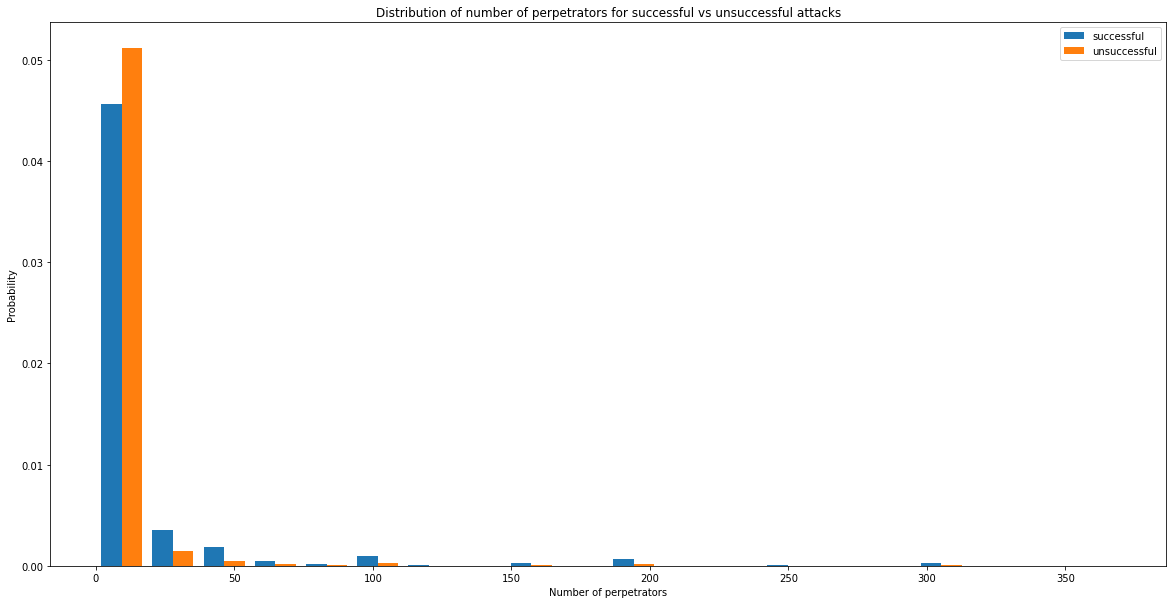

In [191]:
# Number of perpetrators
nperps = terror[['eventid','success','nperps']].dropna()
nperps = nperps[(nperps['nperps'] >= 0) & (nperps['nperps'] < 400)] 
plt.figure(figsize=(20,10))
plt.hist([nperps[nperps['success']==1]['nperps'],nperps[nperps['success']==0]['nperps']], density=True, bins=20, label=['successful','unsuccessful']) 
plt.ylabel('Probability')
plt.xlabel('Number of perpetrators')
plt.legend()
plt.title('Distribution of number of perpetrators for successful vs unsuccessful attacks')

## Mode of Operation

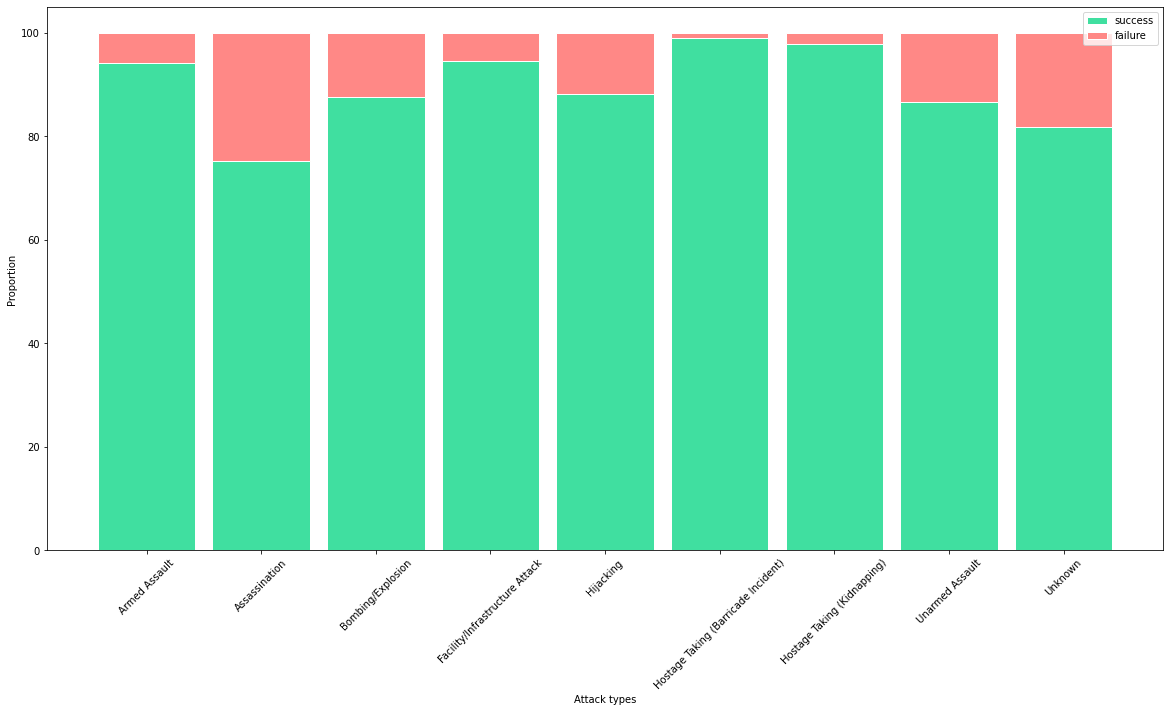

In [252]:
# Attack type
attack = terror[['eventid','attacktype1_txt','success']]\
.groupby(['attacktype1_txt','success'])['eventid']\
.count()\
.to_frame()\
.reset_index()
attack = pd.pivot_table(attack,values='eventid',index=['attacktype1_txt'],columns=['success'])
attack.columns = ['0','1']

attack_type = list(attack.index)
idx = np.arange(len(attack_type))
total = [i+j for i,j in zip(attack['0'], attack['1'])]
success = [i / j * 100 for i,j in zip(attack['1'], total)]
failure = [i / j * 100 for i,j in zip(attack['0'], total)]
plt.figure(figsize=(20,10))
width = 0.85
plt.bar(idx, success, color='#40dfa0', edgecolor='white', width=width,label='success')
plt.bar(idx, failure, bottom=success, color='#ff8886', edgecolor='white', width=width,label='failure')
plt.xticks(idx, attack_type, rotation=45)
plt.xlabel("Attack types")
plt.ylabel("Proportion")
plt.legend()
plt.show()

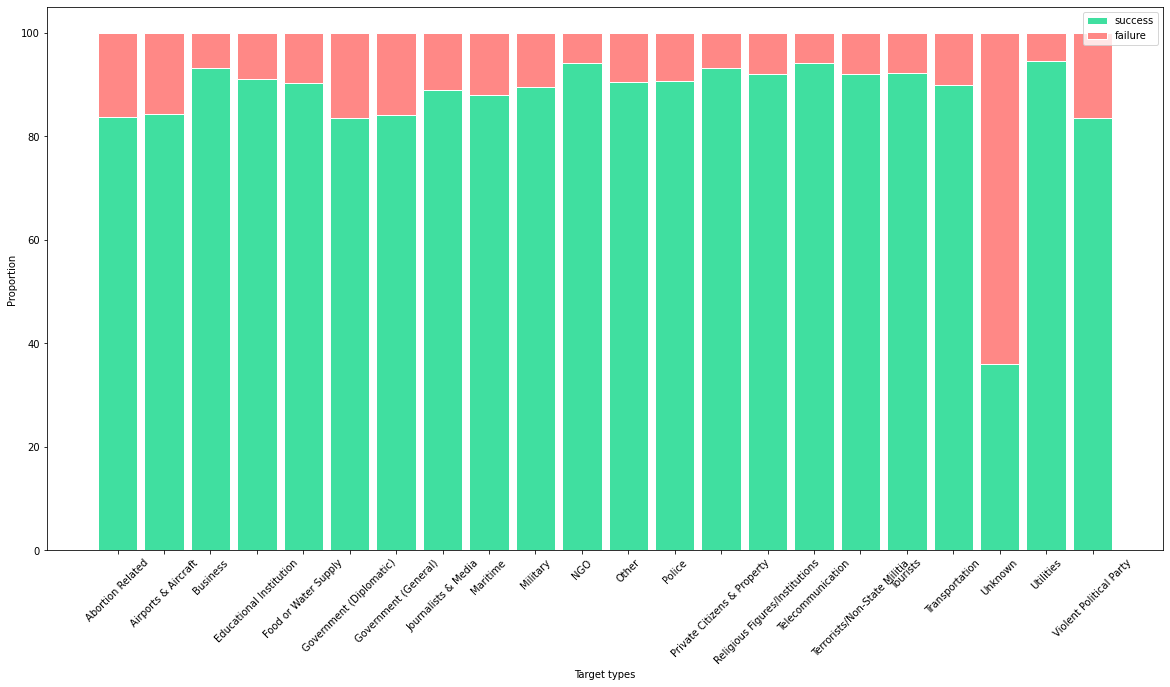

In [253]:
# Target type
target = terror[['eventid','targtype1_txt','success']]\
.groupby(['targtype1_txt','success'])['eventid']\
.count()\
.to_frame()\
.reset_index()
target = pd.pivot_table(target,values='eventid',index=['targtype1_txt'],columns=['success'])
target.columns = ['0','1']

target_type = list(target.index)
idx = np.arange(len(target_type))
total = [i+j for i,j in zip(target['0'], target['1'])]
success = [i / j * 100 for i,j in zip(target['1'], total)]
failure = [i / j * 100 for i,j in zip(target['0'], total)]
plt.figure(figsize=(20,10))
width = 0.85
plt.bar(idx, success, color='#40dfa0', edgecolor='white', width=width,label='success')
plt.bar(idx, failure, bottom=success, color='#ff8886', edgecolor='white', width=width,label='failure')
plt.xticks(idx, target_type, rotation=45)
plt.xlabel("Target types")
plt.ylabel("Proportion")
plt.legend()
plt.show()

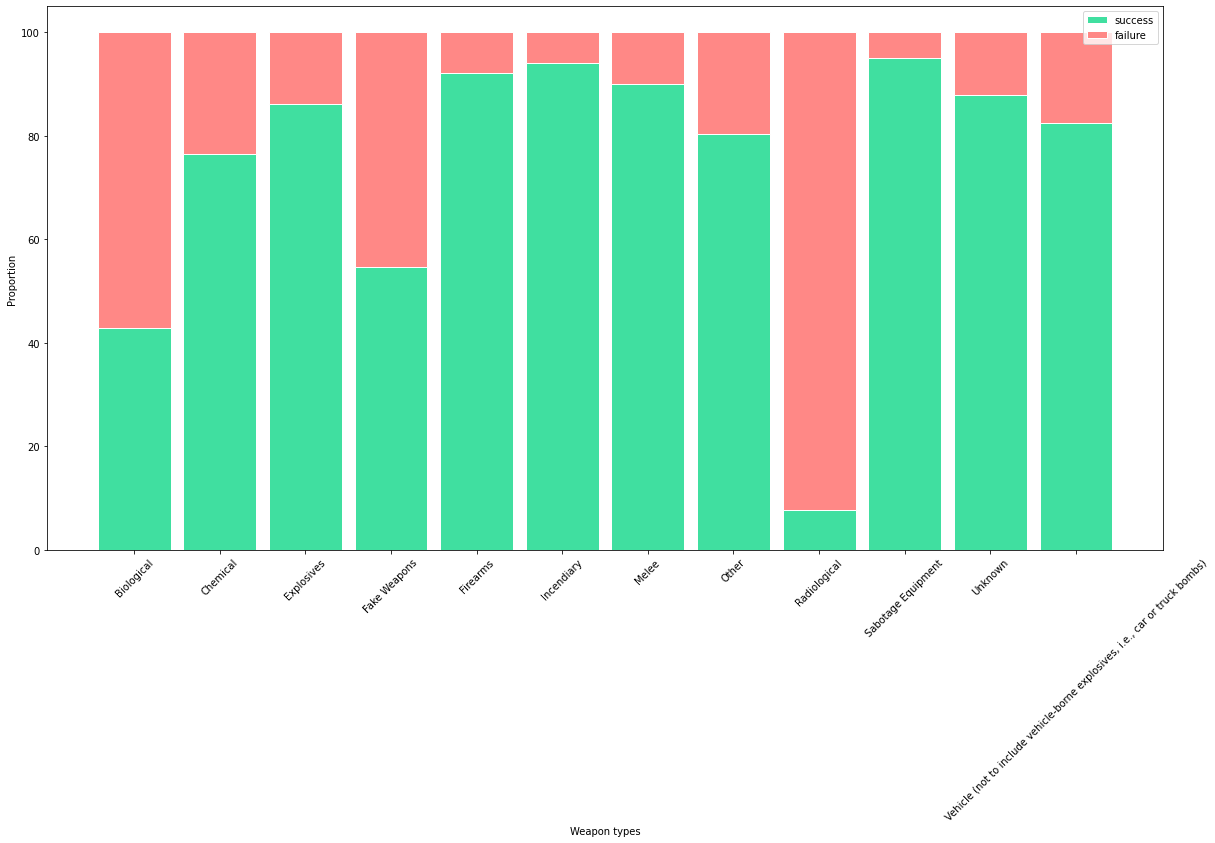

In [255]:
# Weapon type
weapon = terror[['eventid','weaptype1_txt','success']]\
.groupby(['weaptype1_txt','success'])['eventid']\
.count()\
.to_frame()\
.reset_index()
weapon = pd.pivot_table(weapon,values='eventid',index=['weaptype1_txt'],columns=['success'])
weapon.columns = ['0','1']

weapon_type = list(weapon.index)
idx = np.arange(len(weapon_type))
total = [i+j for i,j in zip(weapon['0'], weapon['1'])]
success = [i / j * 100 for i,j in zip(weapon['1'], total)]
failure = [i / j * 100 for i,j in zip(weapon['0'], total)]
plt.figure(figsize=(20,10))
width = 0.85
plt.bar(idx, success, color='#40dfa0', edgecolor='white', width=width,label='success')
plt.bar(idx, failure, bottom=success, color='#ff8886', edgecolor='white', width=width,label='failure')
plt.xticks(idx, weapon_type, rotation=45)
plt.xlabel("Weapon types")
plt.ylabel("Proportion")
plt.legend()
plt.show()

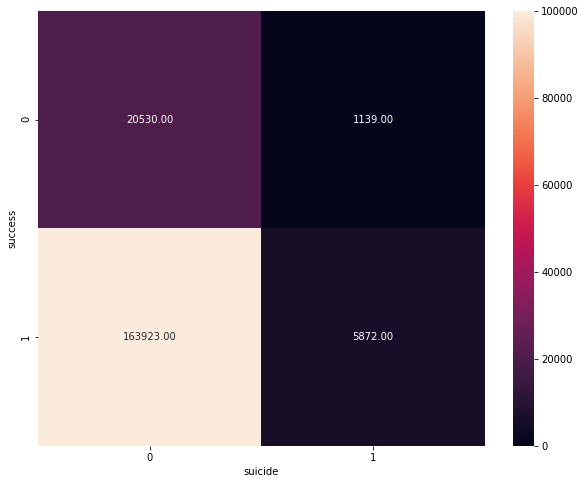

In [272]:
# suicide
suicide = terror[['eventid','suicide','success']]
suicide = suicide[suicide['suicide'] != -9]
suicide = suicide.groupby(['suicide','success'])['eventid'].count().to_frame().reset_index()
suicide = pd.pivot_table(suicide, values='eventid',columns=['suicide'],index=['success'])
fig = plt.figure(figsize=(10,8))
res = sns.heatmap(suicide, annot=True, vmin=0.0, vmax=100000, fmt='.2f')

## Claim of responsibility

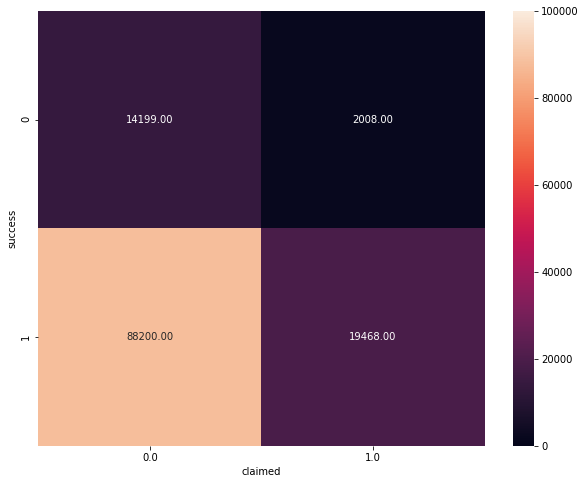

In [178]:
# Claimed
claimed = terror[['eventid','claimed','success']]
claimed = claimed[claimed['claimed'] != -9]
claimed = claimed.groupby(['claimed','success'])['eventid'].count().to_frame().reset_index()
claimed = pd.pivot_table(claimed, values='eventid',columns=['claimed'],index=['success'])
fig = plt.figure(figsize=(10,8))
res = sns.heatmap(claimed, annot=True, vmin=0.0, vmax=100000, fmt='.2f')

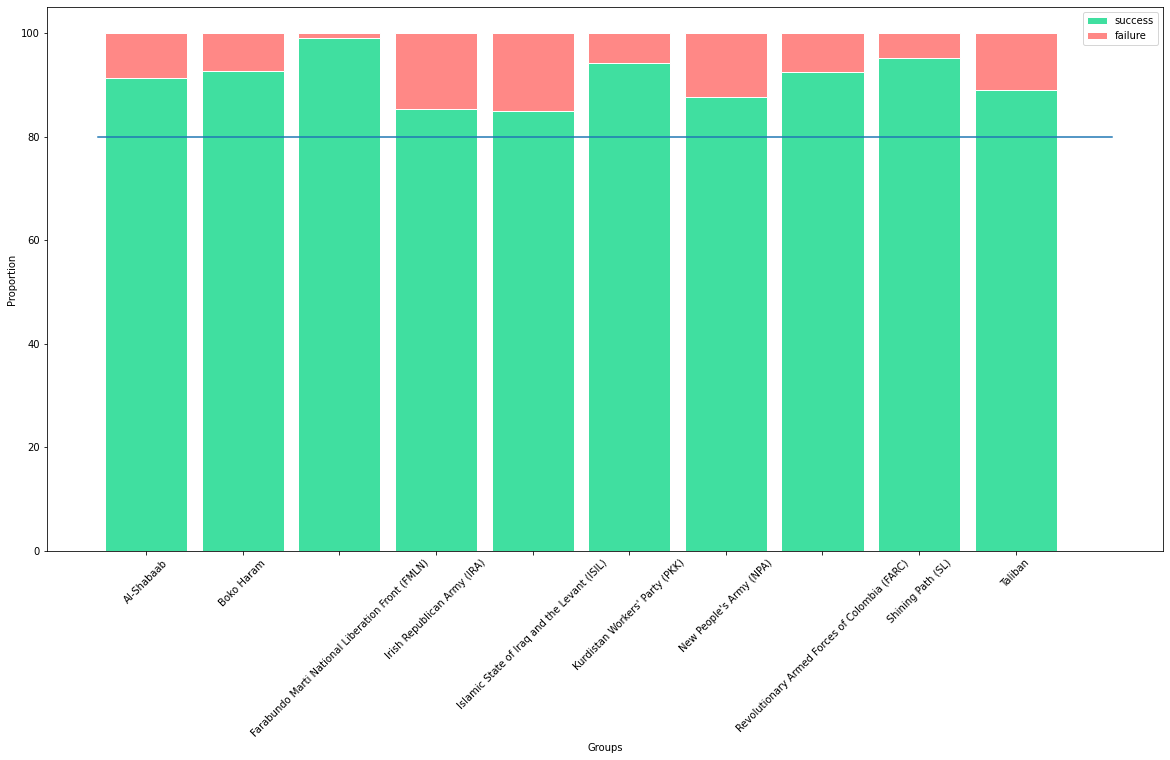

In [271]:
# Group name

# first get top 10 terrorist groups
group_top = terror\
.groupby('gname')['eventid']\
.count()\
.to_frame()\
.reset_index()\
.sort_values('eventid',ascending=False)

group_top = group_top[group_top['gname'] != 'Unknown'][:10]
group_top = group_top.drop('eventid',axis=1)

# look at success rate for top 10 groups
gname = group_top.merge(terror[['eventid','gname','success']],on='gname')\
.groupby(['gname','success'])['eventid']\
.count()\
.to_frame()\
.reset_index()
gname = pd.pivot_table(gname,values='eventid',index=['gname'],columns=['success'])
gname.columns = ['0','1']

gnames = list(gname.index)
idx = np.arange(len(gnames))
total = [i+j for i,j in zip(gname['0'], gname['1'])]
success = [i / j * 100 for i,j in zip(gname['1'], total)]
failure = [i / j * 100 for i,j in zip(gname['0'], total)]
plt.figure(figsize=(20,10))
width = 0.85
plt.bar(idx, success, color='#40dfa0', edgecolor='white', width=width,label='success')
plt.bar(idx, failure, bottom=success, color='#ff8886', edgecolor='white', width=width,label='failure')
plt.xticks(idx, gnames, rotation=45)
plt.xlabel("Groups")
plt.ylabel("Proportion")
plt.legend()
# x_coordinates = [-0.5, 10]
# y_coordinates = [80, 80]
# plt.plot(x_coordinates, y_coordinates)
plt.show()